In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

import sys
sys.path.insert(0, './')

def generateModelV2(working_directory, 
                    number_directory=0, 
                    number_images=0,
                    #number_cluster=10,
                    descriptor_generator="SIFT", 
                    number_feature=200,
                    minimum_size_descriptor=20, 
                    version=""
                   ):
    start_time_model = time.time()

    # class de travail
    from Python.automaticImageIndexing import AutomaticImageIndexing
    automaticImageIndexing = AutomaticImageIndexing()

    print(''.join(['Version : ', automaticImageIndexing.version()]))
    print(''.join(['Data directory : ', automaticImageIndexing.data_directory]))

    automaticImageIndexing.n_limite_directories = number_directory
    automaticImageIndexing.n_limite_images = number_images
    print(''.join(['Max Number of directory : ', str(automaticImageIndexing.n_limite_directories)]))
    print(''.join(['Max Number of picture by directory : ', str(automaticImageIndexing.n_limite_images)]))

    automaticImageIndexing.working_directory = working_directory#'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
    automaticImageIndexing.annotation_directory = 'annotation/'
    automaticImageIndexing.picture_directory = 'images/'
    
    automaticImageIndexing.feature_generator = descriptor_generator
    print('Generator : %s' % automaticImageIndexing.feature_generator)
    automaticImageIndexing.n_feature = number_feature 
    print('Number of feature : %d' % automaticImageIndexing.n_feature)
    automaticImageIndexing.feature_size_min = minimum_size_descriptor
    print('Minimum feature size : %d' % automaticImageIndexing.feature_size_min)
    
    automaticImageIndexing.read_picture_and_feature_generation(with_sub_picture=True, descriptor_generator=descriptor_generator, version=version)
    print("Temps d execution apres parcour image + ORB : %s secondes ---" % (time.time() - start_time_model))

    return automaticImageIndexing

def generateCluster(automaticImageIndexing, number_cluster=None, mode_affichage="", number_cluster_to_show=None):
    start_time_cluster = time.time()
    if(number_cluster is None):
        number_cluster = int(10)
    automaticImageIndexing.n_clusters = number_cluster
    
    automaticImageIndexing.clusturing(automaticImageIndexing.n_clusters)
    print("Temps d execution apres Clustering : %s secondes ---" % (time.time() - start_time_cluster))
    mega_histo = automaticImageIndexing.developBagOfVisualWord()
    print("Temps d execution apres BOV : %s secondes ---" % (time.time() - start_time_cluster))
    automaticImageIndexing.plotHist(mega_histo, automaticImageIndexing.n_clusters, None)
    print("Temps d execution après plot BOV : %s secondes ---" % (time.time() - start_time_cluster))

    if number_cluster_to_show is None :
        number_cluster_to_show = int(number_cluster/2)
    showClusterPicture(
        automaticImageIndexing=automaticImageIndexing,
        mode_affichage=mode_affichage,
        number_cluster_to_show=number_cluster_to_show
    )

def showClusterPicture(automaticImageIndexing, mode_affichage="", number_cluster_to_show=None):
    start_time_showing = time.time()

    if automaticImageIndexing.n_clusters is None:
        print("Veuillez entrainer le model (& generer les cluster) ---")
    else:
        if number_cluster_to_show is None :
            number_cluster_to_show = int(automaticImageIndexing.n_clusters/2)

        if (mode_affichage == "subplot" or mode_affichage == "all"):
            print("affichage subplot des images liées au cluster %d" % number_cluster_to_show)
            automaticImageIndexing.plot_descriptor_in_cluster_subplot_V2(number_cluster_to_show)
            print("Temps d execution apres subplot : %s secondes ---" % (time.time() - start_time_showing))

        if (mode_affichage == "individual_plot" or mode_affichage == "all"):
            print("affichage individuel des images liées au cluster %d" % number_cluster_to_show)
            automaticImageIndexing.plot_descriptor_in_cluster_individualplot(number_cluster_to_show)        
            print("Temps d execution apres individual_plot : %s secondes ---" % (time.time() - start_time_showing))
    

def k_mean_distance_decriptor(data, cantroid_matrix, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid
    distances = [np.linalg.norm(x-cantroid_matrix) for x in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.nanmean(distances), np.nanmin(distances), np.nanmax(distances), len(distances)

def k_mean_distance_all_cluster(model):
    distances = []
    clusters_rates = []
    data = model.np.array(model.desc_list)
    for i_centroid, cantroid_matrix in enumerate(model.kmeans_obj.cluster_centers_):
        # Calculate Euclidean distance for each data point assigned to centroid
        distances = distances + [model.np.linalg.norm(x-cantroid_matrix) for x in data[model.kmeans_ret == i_centroid]]
        # Calculate the rate of cluster for each centroid
        clusters_rates.append(len(data[model.kmeans_ret == i_centroid]))
    return model.np.nanmean(distances), model.np.nanmin(distances), model.np.nanmax(distances), model.np.nanmean(clusters_rates)

def findBestCluster(automaticImageIndexing, number_cluster_min=0, number_cluster_max=100, number_cluster_step=25, show_intermediate_distance=None):
    start_time_cluster_optimizing = time.time()
    
    if automaticImageIndexing.n_clusters is None:
        print("Veuillez entrainer le model (et generer les clusters) ---")
    else:
        result = []
        nb_descriptor_total = len(automaticImageIndexing.desc_list) * 1.0 #1.0 to convert int in decimal
        print("nb descriptor : %s" % nb_descriptor_total)
        
        mean_distances_all_cluster = []
        max_distances_all_cluster = []
        min_distances_all_cluster = []
        perform_indicator_nb_descriptor_all_cluster=[]
        perform_indicator_descripor_all_cluster=[]

        for nb_cluster in range(number_cluster_min, number_cluster_max, number_cluster_step):
            print("-----------------------------------------------------------------------------------------")
            print("--------------------------------- start test cluster %s ---------------------------------" % str(nb_cluster))
            generateCluster(
                automaticImageIndexing=automaticImageIndexing,
                number_cluster=nb_cluster
            )
            
            centroids = model.kmeans_obj.cluster_centers_            
            if show_intermediate_distance == True:
                mean_distances = []
                max_distances = []
                min_distances = []
                descriptors_rate = []
                for i, cent_features in enumerate(centroids):
                    mean_distance, max_distance, min_distance, number_descriptor = k_mean_distance_decriptor(
                        automaticImageIndexing.np.array(automaticImageIndexing.desc_list), 
                        cent_features,
                        i,
                        automaticImageIndexing.kmeans_ret
                    )
                    mean_distances.append(mean_distance)
                    max_distances.append(max_distance)
                    min_distances.append(min_distance)
                    
                    perform_indicator_descripor = (number_descriptor / nb_descriptor_total)
                    descriptors_rate.append(perform_indicator_descripor)
                fig, axs = automaticImageIndexing.plt.subplots(nrows=1, ncols=2, constrained_layout=False)
                clusters_numero = range(nb_cluster)
                axs[0].plot(clusters_numero, mean_distances)
                axs[0].plot(clusters_numero, max_distances)
                axs[0].plot(clusters_numero, min_distances)
                
                axs[0].set_xlabel('Cluster', fontsize=12)
                axs[0].set_ylabel('Distance', fontsize=12)
                axs[0].set_title('Distances by Cluster', fontsize=12)
                
                axs[1].plot(clusters_numero, descriptors_rate)
                
                axs[1].set_xlabel('Cluster', fontsize=12)
                axs[1].set_ylabel('Descriptor Rate', fontsize=12)
                axs[1].set_title('Descriptor Rate by cluster', fontsize=12)
                automaticImageIndexing.plt.show()
            
            mean_distance_all_cluster, max_distance_all_cluster, min_distance_all_cluster, mean_number_descriptor = k_mean_distance_all_cluster(
                automaticImageIndexing
            )
            mean_distances_all_cluster.append(mean_distance_all_cluster)
            max_distances_all_cluster.append(max_distance_all_cluster)
            min_distances_all_cluster.append(min_distance_all_cluster)
            
            print(mean_number_descriptor)
            print(nb_descriptor_total)
            
            print(mean_number_descriptor / nb_descriptor_total)
            
            perform_indicator_distance = mean_number_descriptor / nb_descriptor_total
            
            perform_indicator_nb_descriptor_all_cluster.append(perform_indicator_distance)
            
            print("--------------------------------- sop test cluster %s ---------------------------------" % str(nb_cluster))
    clusters_numbers = range(number_cluster_min, number_cluster_max, number_cluster_step)
    
    fig, axs = automaticImageIndexing.plt.subplots(nrows=1, ncols=2, constrained_layout=False)
    axs[0].plot(clusters_numbers, mean_distances_all_cluster, label="mean")
    axs[0].plot(clusters_numbers, max_distances_all_cluster, label="max")
    axs[0].plot(clusters_numbers, min_distances_all_cluster, label="min")

    axs[0].set_xlabel('Cluster', fontsize=12)
    axs[0].set_ylabel('Distance moyenne', fontsize=12)
    axs[0].set_title('Distances moyenne by number of Cluster', fontsize=12)

    axs[1].plot(clusters_numbers, perform_indicator_nb_descriptor_all_cluster, label="indicateur Nb Descripteur moyen")

    axs[1].set_xlabel('Cluster', fontsize=12)
    axs[1].set_ylabel('Descriptor Rate', fontsize=12)
    axs[1].set_title('Descriptor Rate by number of Cluster', fontsize=12)
    #automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.divide(mean_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.divide(min_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.divide(max_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.divide(perform_indicator_nb_descriptor_all_cluster,mean_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.divide(perform_indicator_nb_descriptor_all_cluster,min_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.divide(perform_indicator_nb_descriptor_all_cluster,max_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.multiply(mean_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.multiply(min_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.multiply(max_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    print("array normalisees")
    
    mean_distances_all_cluster = normalize([mean_distances_all_cluster], axis=1, norm='l1')[0]
    max_distances_all_cluster = normalize([max_distances_all_cluster], axis=1, norm='l1')[0]
    min_distances_all_cluster = normalize([min_distances_all_cluster], axis=1, norm='l1')[0]
    perform_indicator_nb_descriptor_all_cluster = normalize([perform_indicator_nb_descriptor_all_cluster], axis=1, norm='l1') [0]   
    
    fig, axs = automaticImageIndexing.plt.subplots(nrows=1, ncols=2, constrained_layout=False)
    axs[0].plot(clusters_numbers, mean_distances_all_cluster, label="mean")
    axs[0].plot(clusters_numbers, max_distances_all_cluster, label="max")
    axs[0].plot(clusters_numbers, min_distances_all_cluster, label="min")

    axs[0].set_xlabel('Cluster', fontsize=12)
    axs[0].set_ylabel('Distance moyenne', fontsize=12)
    axs[0].set_title('Distances moyenne by number of Cluster', fontsize=12)

    axs[1].plot(clusters_numbers, perform_indicator_nb_descriptor_all_cluster, label="indicateur Nb Descripteur moyen")

    axs[1].set_xlabel('Cluster', fontsize=12)
    axs[1].set_ylabel('Descriptor Rate', fontsize=12)
    axs[1].set_title('Descriptor Rate by number of Cluster', fontsize=12)
    #automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.divide(mean_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.divide(min_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.divide(max_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.divide(perform_indicator_nb_descriptor_all_cluster,mean_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.divide(perform_indicator_nb_descriptor_all_cluster,min_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.divide(perform_indicator_nb_descriptor_all_cluster,max_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.multiply(mean_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.multiply(min_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.multiply(max_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    print("Temps d execution optimisation : %s secondes ---" % (time.time() - start_time_cluster_optimizing))


Version : 0.4
Data directory : Data/
Max Number of directory : 2
Max Number of picture by directory : 2
Generator : ORB
Number of feature : 60
Minimum feature size : 20
Computing Features for  n02085620-Chihuahua
Computing Features for  n02085782-Japanese_spaniel
Temps d execution apres parcour image + ORB : 0.390000104904 secondes ---
nb descriptor : 181.0
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 1 ---------------------------------
Temps d execution apres Clustering : 0.0 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 0.0 secondes ---
Plotting histogram


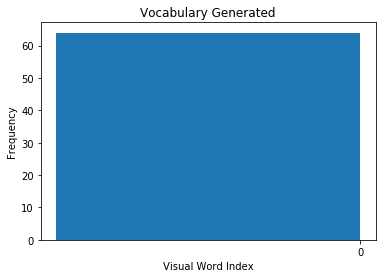

Temps d execution après plot BOV : 0.138999938965 secondes ---


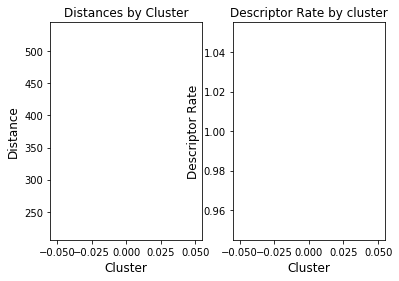

181.0
181.0
1.0
--------------------------------- sop test cluster 1 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 2 ---------------------------------
Temps d execution apres Clustering : 0.0230000019073 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 0.0230000019073 secondes ---
Plotting histogram


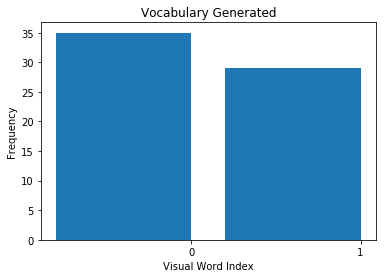

Temps d execution après plot BOV : 0.131999969482 secondes ---


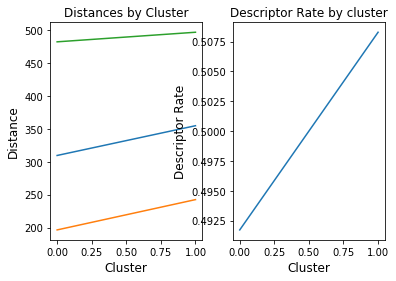

90.5
181.0
0.5
--------------------------------- sop test cluster 2 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 3 ---------------------------------
Temps d execution apres Clustering : 0.0490000247955 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 0.0490000247955 secondes ---
Plotting histogram


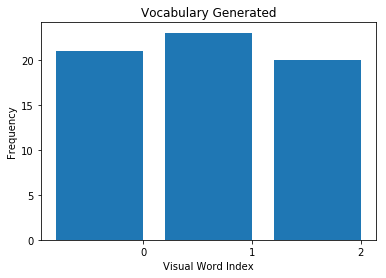

Temps d execution après plot BOV : 0.158999919891 secondes ---


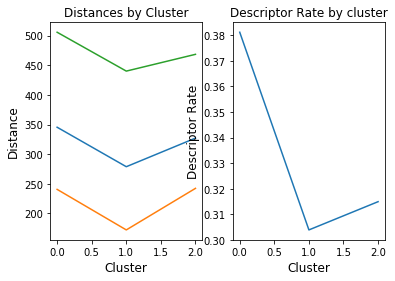

60.333333333333336
181.0
0.33333333333333337
--------------------------------- sop test cluster 3 ---------------------------------


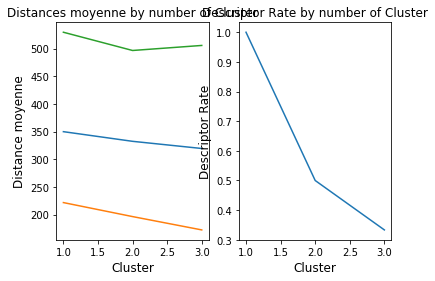

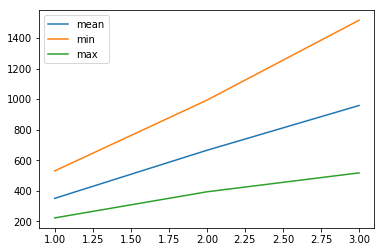

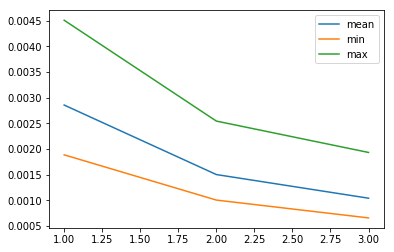

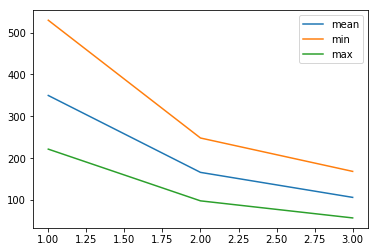

array normalisees


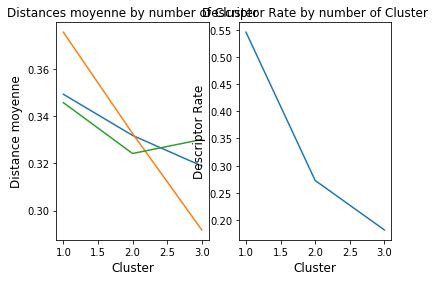

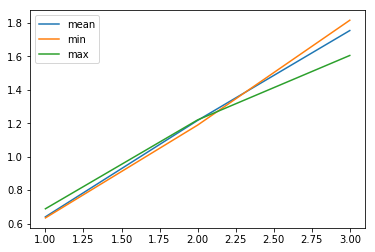

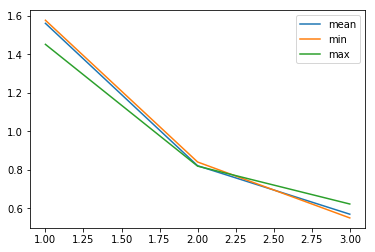

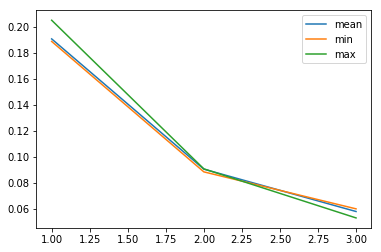

Temps d execution optimisation : 2.55599999428 secondes ---


In [2]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=2,#40, 
        number_images=2,#20,
        descriptor_generator="ORB",
        minimum_size_descriptor=20,
        version="V2"
    )

start = 1
stop = 4
step = 1
tableau_perf = findBestCluster(model, start, stop, step,
        show_intermediate_distance=True)
tableau_perf

In [3]:
print(model.n_clusters)
#print(model.picture_detail_list)
print(model.picture_detail_list[0:4])
#print(model.picture_detail_list[0][0:6])
#print(model.picture_detail_list[0:][7])

3
[['C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/images/n02085620-Chihuahua/n02085620_10074.jpg', u'25', u'10', u'276', u'498', [<KeyPoint 00000000100E0720>, <KeyPoint 00000000100E0750>, <KeyPoint 00000000100E0780>, <KeyPoint 00000000100E07B0>, <KeyPoint 00000000100E07E0>, <KeyPoint 00000000100E0810>, <KeyPoint 00000000100E0840>, <KeyPoint 00000000100E0870>, <KeyPoint 00000000100E08A0>, <KeyPoint 00000000100E08D0>, <KeyPoint 00000000100E0900>, <KeyPoint 00000000100E0930>, <KeyPoint 00000000100E0960>, <KeyPoint 00000000100E0990>, <KeyPoint 00000000100E09C0>, <KeyPoint 00000000100E09F0>, <KeyPoint 00000000100E0A20>, <KeyPoint 00000000100E0A50>, <KeyPoint 00000000100E0A80>, <KeyPoint 00000000100E0AB0>, <KeyPoint 00000000100E0AE0>, <KeyPoint 00000000100E0B10>, <KeyPoint 00000000100E0B40>, <KeyPoint 00000000100E0B70>, <KeyPoint 00000000100E0BA0>, <KeyPoint 00000000100E0BD0>, <KeyPoint 00000000100E0C00>, <KeyPoint 00000000100E0C30>, <KeyPoint 00000000100E0C60>, <KeyPo

In [4]:
_entire = [x[0:4] for x in model.picture_detail_list]
X_entire = [x[6] for x in model.picture_detail_list]

y_entire = [x[7] for x in model.picture_detail_list]
print(X_entire)
print(y_entire)

[array([[161,  21,  94, ...,  57,  69,  63],
       [ 85, 114, 106, ...,  24,  56,  50],
       [ 78,  77, 168, ...,  15,  28, 226],
       ...,
       [ 74,  66,  32, ...,  79,  13,  24],
       [111,  79, 230, ...,   6, 120, 224],
       [ 40,  95, 184, ..., 123, 148,  80]], dtype=uint8), array([[106,  98, 172, ..., 134,  13,   8],
       [198, 151, 255, ...,  75, 128, 217],
       [255,  54, 126, ..., 206, 141,  57],
       ...,
       [239, 123,  63, ..., 237,  57,   9],
       [111,  87,  42, ...,  25,  28,   8],
       [ 67, 149, 187, ...,  73,  81, 127]], dtype=uint8), array([[203, 151,  31, ...,  69, 200,  29],
       [ 74, 145,  57, ...,  79,  45,  58],
       [235,  91,  42, ..., 107,  24,  16],
       ...,
       [239,  79,  68, ...,  13,  28,   8],
       [103,  79, 166, ...,  11,  84, 192],
       [107,  85,  58, ...,  11,  28,  50]], dtype=uint8), array([[161, 119,  56,  93, 113, 178,   6, 183,   9,  35, 192, 247, 193,
         56, 230, 168, 210,  52, 126,   6, 194, 174, 

In [5]:
model_predict = model.train_predict()

predict score = 1.0
Training completed


C:\Users\naru_\Anaconda3\envs\opencv2\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Plotting histogram


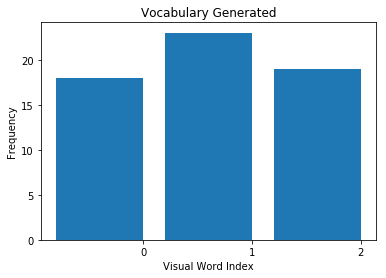

Plotting histogram


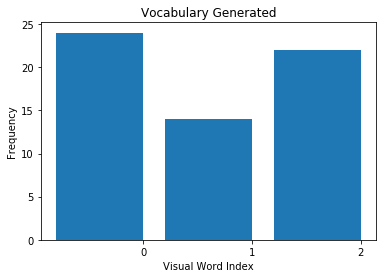

Plotting histogram


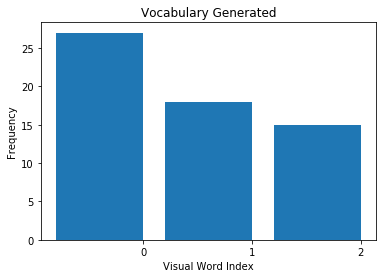

Plotting histogram


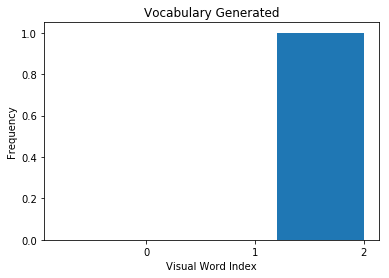

[u'Chihuahua', u'Chihuahua', u'Japanese_spaniel', u'Japanese_spaniel']
[u'Chihuahua', u'Chihuahua', u'Japanese_spaniel', u'Japanese_spaniel']
predict score = 0.0
Training completed


In [41]:
#from sklearn.model_selection import train_test_split


import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path

#import progressbar
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from xml.dom import minidom

def picture_in_BOV (model, picture_path, picture_descriptors, show_graph=None, reload_descriptor=None):
        if (reload_descriptor is None) or (reload_descriptor == False):
            image_descriptions = picture_descriptors
        else:
            image, image_filtered = model.canny(image_path=picture_path)
            is_gray = True
            image_kp, image_descriptions, image_partials = model.feature_sift_generation(image_filtered, is_gray, False)

        image_clustered = model.kmeans_obj.predict(image_descriptions)
        # generate vocab for test image
        clusters = model.np.array( [[ 0 for i in range(model.n_clusters)]])
        # locate nearest clusters for each of 
        # the visual word (feature) present in the 0:6
        # print vocab
        for each in image_clustered:
            clusters[0][each] += 1
        
        if (show_graph is None) or (show_graph == True):    
            model.plotHist(clusters, model.n_clusters, None)
        return clusters    

def train_predict(model, with_reload_descriptor=None, with_performance_measure=None):
        X=[k[6] for k in model.picture_detail_list] # kps save previously
        X_desc = []
        i=0
        y_desc = []
        for x_temp in X:
            if (with_reload_descriptor is None) or (with_reload_descriptor == False):
                if (x_temp is not None) and (len(x_temp)>0):
                #X_desc.extend(picture_in_BOV(model, picture_path=None, picture_descriptors=x_temp))
                    X_desc.extend(model.picture_in_BOV(picture_path=None, picture_descriptors=x_temp))
                    y_desc.extend([model.picture_detail_list[i][7]])
                    
                i=i+1
 
            else:
                X_desc.extend(model.picture_in_BOV(picture_path=x_temp[0], picture_descriptors=None))
                y_desc = [r[7] for r in self.picture_detail_list]

        X_train, X_test, y_train, y_test = model.model_selection.train_test_split(list(X_desc), y_desc, test_size=0.20, random_state=42) # pb ne fonctionne pas avec le train_test_split de la class
        #X_train, X_test, y_train, y_test = train_test_split(X_desc, y, test_size=0.25, random_state=42)
        """
        uses sklearn.svm.SVC classifier (SVM) 
        """
        model.clf.fit(X_train, y_train)
        
        if (with_performance_measure is None) or (with_performance_measure == True):
            score = model.clf.score(X_test, y_test)
            print"predict score = %s" % score
        
        print "Training completed"
train_predict(model)

In [34]:
model.picture_detail_list[0][7]

u'Chihuahua'

In [7]:
[x[7] for x in model.picture_detail_list][0]

u'Chihuahua'

In [8]:
[x[6] for x in model.picture_detail_list][0]

array([[161,  21,  94, ...,  57,  69,  63],
       [ 85, 114, 106, ...,  24,  56,  50],
       [ 78,  77, 168, ...,  15,  28, 226],
       ...,
       [ 74,  66,  32, ...,  79,  13,  24],
       [111,  79, 230, ...,   6, 120, 224],
       [ 40,  95, 184, ..., 123, 148,  80]], dtype=uint8)

Version : 0.4
Data directory : Data/
Max Number of directory : 0
Max Number of picture by directory : 50
Generator : ORB
Number of feature : 60
Minimum feature size : 20
Computing Features for  n02085620-Chihuahua
Computing Features for  n02085782-Japanese_spaniel
Computing Features for  n02085936-Maltese_dog
Computing Features for  n02086079-Pekinese
Computing Features for  n02086240-Shih-Tzu
Computing Features for  n02086646-Blenheim_spaniel
Computing Features for  n02086910-papillon
Computing Features for  n02087046-toy_terrier
Computing Features for  n02087394-Rhodesian_ridgeback
Computing Features for  n02088094-Afghan_hound
Computing Features for  n02088238-basset
Computing Features for  n02088364-beagle
Computing Features for  n02088466-bloodhound
Computing Features for  n02088632-bluetick
Computing Features for  n02089078-black-and-tan_coonhound
Computing Features for  n02089867-Walker_hound
Computing Features for  n02089973-English_foxhound
Computing Features for  n02090379-re

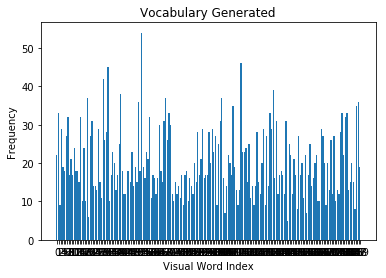

Temps d execution après plot BOV : 3551.9059999 secondes ---


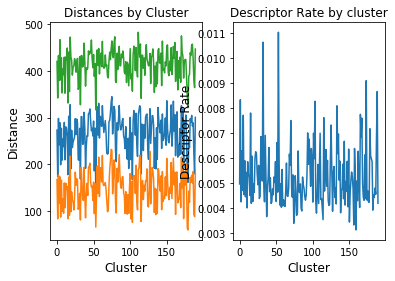

1797.0473684210526
341439.0
0.005263157894736842
--------------------------------- sop test cluster 190 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 200 ---------------------------------
Temps d execution apres Clustering : 3793.13199997 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 3793.148 secondes ---
Plotting histogram


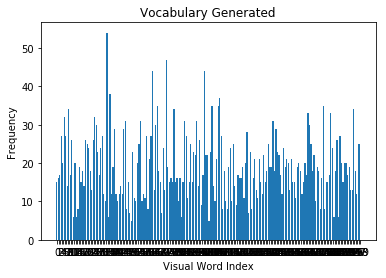

Temps d execution après plot BOV : 3794.54799986 secondes ---


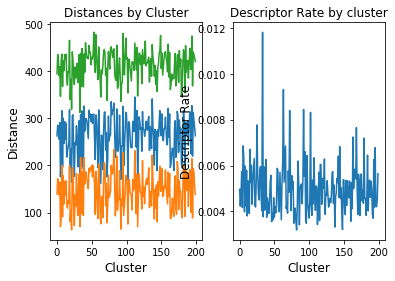

1707.195
341439.0
0.005
--------------------------------- sop test cluster 200 ---------------------------------


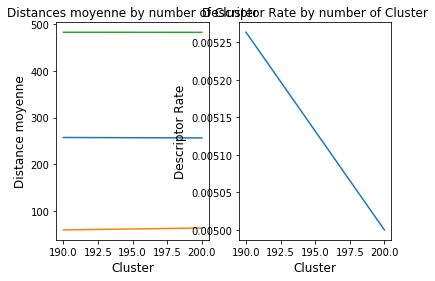

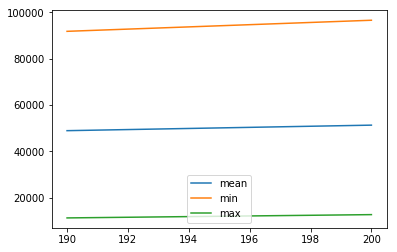

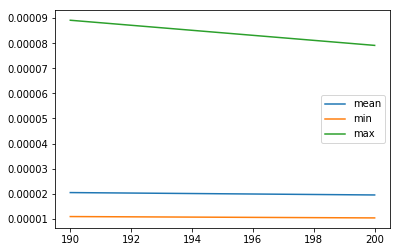

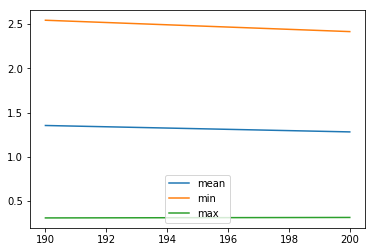

array normalisees


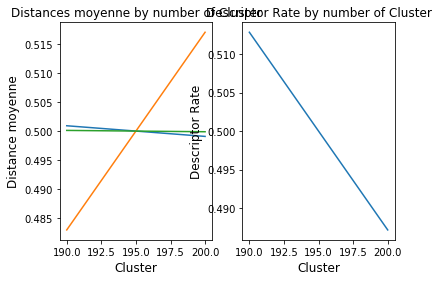

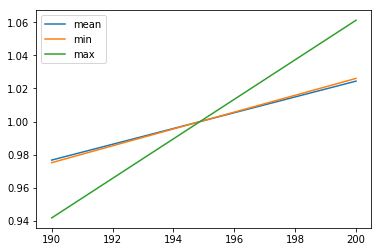

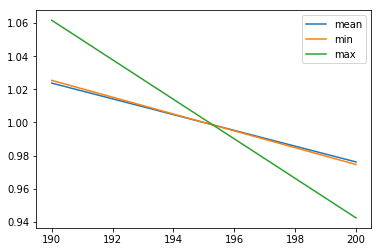

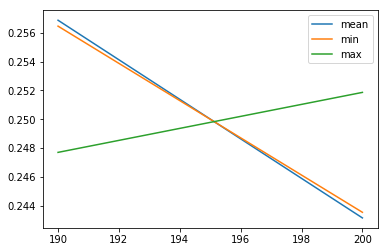

Temps d execution optimisation : 7397.96499991 secondes ---


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [2]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=0, 
        number_images=50,
        descriptor_generator="ORB",
        minimum_size_descriptor=20,
        version="V2"
    )

start = 190
stop = 210
step = 10
tableau_perf = findBestCluster(model, start, stop, step,
        show_intermediate_distance=True)
print(tableau_perf)

model_predict = model.train_predict()

In [3]:
model_predict = model.train_predict()

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

-----***----- description 0
[[161  21  94 ...  57  69  63]
 [ 85 114 106 ...  24  56  50]
 [ 78  77 168 ...  15  28 226]
 ...
 [ 74  66  32 ...  79  13  24]
 [111  79 230 ...   6 120 224]
 [ 40  95 184 ... 123 148  80]]
-----***-----
Plotting histogram


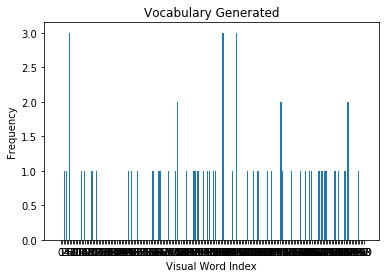

-----***----- description 1
[[106  98 172 ... 134  13   8]
 [198 151 255 ...  75 128 217]
 [255  54 126 ... 206 141  57]
 ...
 [239 123  63 ... 237  57   9]
 [111  87  42 ...  25  28   8]
 [ 67 149 187 ...  73  81 127]]
-----***-----
Plotting histogram


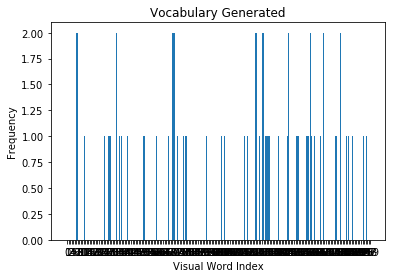

-----***----- description 2
[[106 219  40 ... 123  13  50]
 [ 75 113  40 ...  75   5  56]
 [104  90  42 ...  11 149   8]
 ...
 [234 155  92 ...  75 133   9]
 [236 219 173 ... 111   7 192]
 [106 203 100 ...  79  13   0]]
-----***-----
Plotting histogram


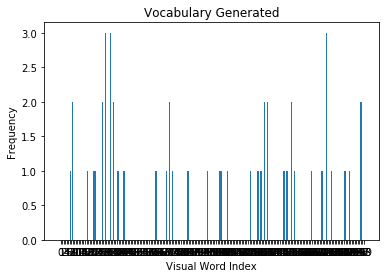

-----***----- description 3
[[169  87  58 ...  24 129   9]
 [233  19  31 ... 125  12  23]
 [111  95  59 ... 105  48  50]
 ...
 [247  80 107 ...  12  56 226]
 [231  95 146 ...  73  93  72]
 [229  95  58 ... 121  21  50]]
-----***-----
Plotting histogram


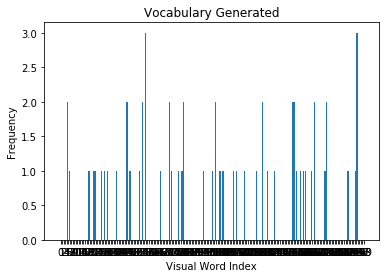

-----***----- description 4
[[ 85 102 162 ...   9  64 178]
 [ 12  87 232 ... 185  71   8]
 [ 79  67 162 ...   3  69 200]
 ...
 [107  75 102 ...  11  29   0]
 [103 119  42 ...  41  16  34]
 [109  69 120 ... 123   4  50]]
-----***-----
Plotting histogram


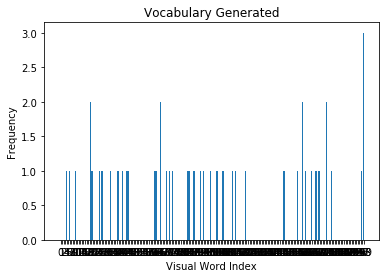

-----***----- description 5
[[197  31 125 ... 233 144  29]
 [238  79 190 ... 205 122  64]
 [231  31  89 ...  15  76 133]
 ...
 [239  95  62 ...  73  60   1]
 [239  95  62 ...  77  60  96]
 [239  95  62 ...  73  28   0]]
-----***-----
Plotting histogram


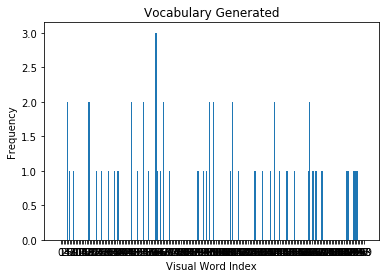

-----***----- description 6
[[234 155 191 ...  77   8 241]
 [107  19  58 ... 107   5  24]
 [238 151 190 ...  73 196  85]
 ...
 [ 78  67 176 ... 123  15 148]
 [153  46 195 ...  18  78 231]
 [110 199 228 ...   3  85  77]]
-----***-----
Plotting histogram


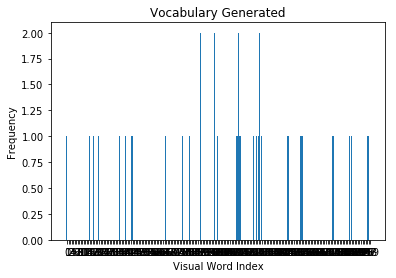

-----***----- description 7
[[206  27  61 ... 235  13  17]
 [180 116 176 ... 170  87 217]
 [ 99 175 198 ...   3  72 196]
 ...
 [ 75 193 246 ...  77  32 153]
 [239 149 181 ...  79 124 215]
 [234 153  29 ... 205  28  21]]
-----***-----
Plotting histogram


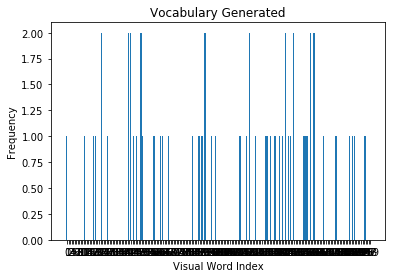

-----***----- description 8
[[ 66  19  41 ...  74  12  16]
 [233  91 186 ...  75 128   0]
 [ 72 102 104 ...  10   4  50]
 ...
 [239  91  38 ...   7 124 192]
 [238 139 149 ...  79  25 205]
 [ 66 155  55 ...  75 165  25]]
-----***-----
Plotting histogram


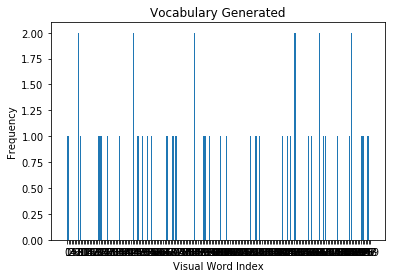

-----***----- description 9
[[ 45 110 224 ... 154  79 234]
 [127 100 132 ...  10  88 226]
 [234 159 188 ...  75 149  88]
 ...
 [119 110  38 ...  10  93 106]
 [239  79 211 ...  93 250 196]
 [234 139 149 ...  87 204 197]]
-----***-----
Plotting histogram


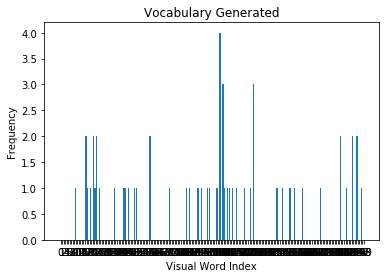

-----***----- description 10
[[165  85  25 ... 191  63  51]
 [215 102 196 ...   8  88 224]
 [ 79  31  58 ...  75 104  17]
 ...
 [223  12 243 ...  10 112 231]
 [111  87  62 ...  75  61  56]
 [111  87  46 ...  73  53   8]]
-----***-----
Plotting histogram


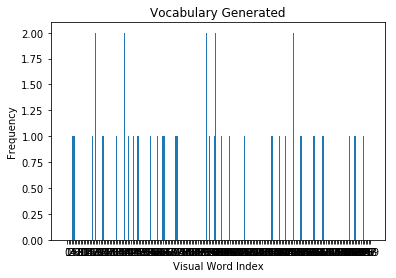

-----***----- description 11
[[233  69 164 ... 128 199 201]
 [175 111  98 ... 132 127 192]
 [250 202 237 ...  86  25 226]
 ...
 [235  87  30 ... 127  52  82]
 [234 153  63 ... 207  60   5]
 [167  87  58 ...  41  57  58]]
-----***-----
Plotting histogram


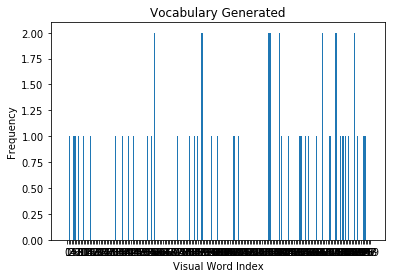

-----***----- description 12
[]
-----***-----


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [13]:
train_predict(model)

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
del model
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=0, 
        number_images=150,
        descriptor_generator="ORB",
        minimum_size_descriptor=20,
        version="V2"
    )

start = 190
stop = 210
step = 10
tableau_perf = findBestCluster(model, start, stop, step,
        show_intermediate_distance=True)
tableau_perf

model_predict = model.train_predict()